# Flight Planning Domain 

This notebook aims to make a short and interactive example of the Flight Planning Domain. See the [online documentation](https://airbus.github.io/scikit-decide/reference/_skdecide.hub.domain.flight_planning.domain.html#flightplanningdomain) for more information.

Concerning the python kernel to use for this notebook:
- If running locally, be sure to use an environment with scikit-decide[all] and minizinc.
- If running on colab, the next cell does it for you.
- If running on binder, the environment should be ready.

In [1]:
# On Colab: install the library
on_colab = "google.colab" in str(get_ipython())
if on_colab:
    import glob
    import importlib
    import json
    import os
    import sys

    using_nightly_version = True

    if using_nightly_version:
        # look for nightly build download url
        release_curl_res = !curl -L   -H "Accept: application/vnd.github+json" -H "X-GitHub-Api-Version: 2022-11-28" https://api.github.com/repos/airbus/scikit-decide/releases/tags/nightly
        release_dict = json.loads(release_curl_res.s)
        release_download_url = sorted(
            release_dict["assets"], key=lambda d: d["updated_at"]
        )[-1]["browser_download_url"]
        print(release_download_url)

        # download and unzip
        !wget --output-document=release.zip {release_download_url}
        !unzip -o release.zip

        # get proper wheel name according to python version used
        wheel_pythonversion_tag = f"cp{sys.version_info.major}{sys.version_info.minor}"
        wheel_path = glob.glob(
            f"dist/scikit_decide*{wheel_pythonversion_tag}*manylinux*.whl"
        )[0]

        skdecide_pip_spec = f"{wheel_path}[all]"
    else:
        skdecide_pip_spec = "scikit-decide[all]"

    # uninstall google protobuf conflicting with ray and sb3
    ! pip uninstall -y protobuf

    # install scikit-decide with all extras
    !pip install {skdecide_pip_spec}

    # be sure to load the proper cffi (downgraded compared to the one initially on colab)
    import cffi

    importlib.reload(cffi)

    # install and configure minizinc
    !curl -o minizinc.AppImage -L https://github.com/MiniZinc/MiniZincIDE/releases/download/2.6.3/MiniZincIDE-2.6.3-x86_64.AppImage
    !chmod +x minizinc.AppImage
    !./minizinc.AppImage --appimage-extract
    os.environ["PATH"] = f"{os.getcwd()}/squashfs-root/usr/bin/:{os.environ['PATH']}"
    os.environ[
        "LD_LIBRARY_PATH"
    ] = f"{os.getcwd()}/squashfs-root/usr/lib/:{os.environ['LD_LIBRARY_PATH']}"

In [2]:
import datetime


from skdecide.hub.domain.flight_planning.domain import FlightPlanningDomain, WeatherDate
from skdecide.hub.solver.astar import Astar

# reload
%load_ext autoreload
%autoreload 2

## Definition of the problem

Here we will make a short haul flight from Paris Charles de Gaulle airport (ICAO : LFPG) to Toulouse-Blagnac airport (ICAO: LFBO), using an airbus A320 aircraft.

In [3]:
origin = "LFPG"
destination = "LFBO"
aircraft = "A320"

Now, we are going to define a date that will be used for weather interpolation. If the data has not already be downloaded on your computer, be careful to choose a date within the past 6 months, so that the data is available on https://www.ncei.noaa.gov.

In [4]:
# we set a date valid for 4 months to avoid downloading weather data at each daily run.
today = datetime.date.today()
month = ((today.month) - 1) // 4 * 4 + 1  # will result in january, may, or september
year = today.year
day = 1

weather_date = WeatherDate(day=day, month=month, year=year)
print(weather_date)

[01 01 2024, forecast : nowcast]


We can now define heuristic and cost function, to feed the A* solver. This aims to guide him along the airways graph to solve the problem, and get as close as possible to the optimal solution. 

The heuristic function can be either `"fuel"`, `"time"`, `"distance"`, `"lazy_fuel"`, `"lazy_time"`, or `None`. If `None`, the A* will behave as a Dijkstra-like search algorithm, as we give a 0 value to the A* algorithm. 

The cost function can be either `"fuel"`, `"time"`, or `"distance"`. 
It will define the cost of the flight plan, computed during the state-to-state flight simulation. 

In [5]:
heuristic = "fuel"
cost_function = "fuel"

## Definition of the corresponding domain

We are now going to define the domain. It can take some time, especially if it needs to download some weather files, or if you ask for a fuel loop. 


In [6]:
domain_factory = lambda: FlightPlanningDomain(
    origin,
    destination,
    aircraft,
    weather_date=weather_date,
    heuristic_name=heuristic,
    perf_model_name="openap", # a/c performance model
    objective=cost_function,
    fuel_loop=False,
    graph_width="normal",
)

domain = domain_factory()

## Solving and rendering out the flight planning

We use here an A* solver as mentionned before. 
We also use the custom rollout proposed to have some visualization during the flight planning generation.

/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


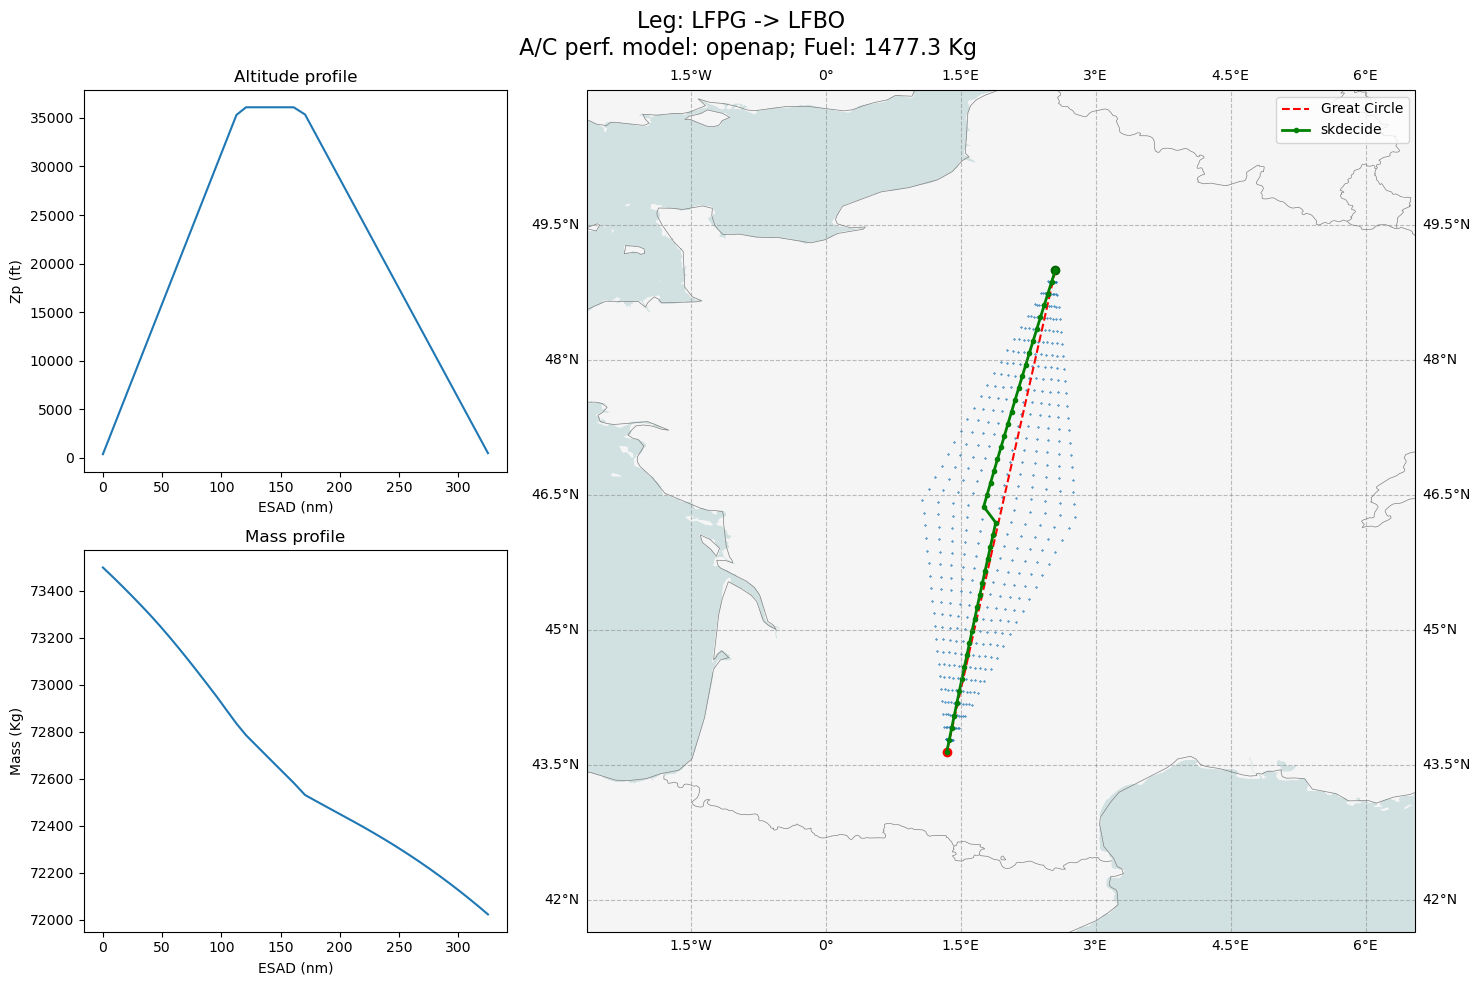

Goal reached after 40 steps!


In [7]:
with Astar(
heuristic=lambda d, s: d.heuristic(s), domain_factory=domain_factory, parallel=False
) as solver:
    domain.solve_with(
        solver=solver, 
        domain_factory=domain_factory)

    domain.custom_rollout(
        solver=solver)

## Changing aircraft performance model

One of the new features of the flight planning domain is the addition of another aircraft performance model. Indeed, the default is OpenAP (`openap`) but we can now choose [Poll-Schumann](https://elib.dlr.de/135592/1/Poll_Schumann_estimation_method_fuel_burn_performance_aircraft_cruise_part_1_fundamentals_2020.pdf) (`PS`), which is more accurate.

Thus, we can run the solver on the domain with a Poll-Schumann A/C performance model:

/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


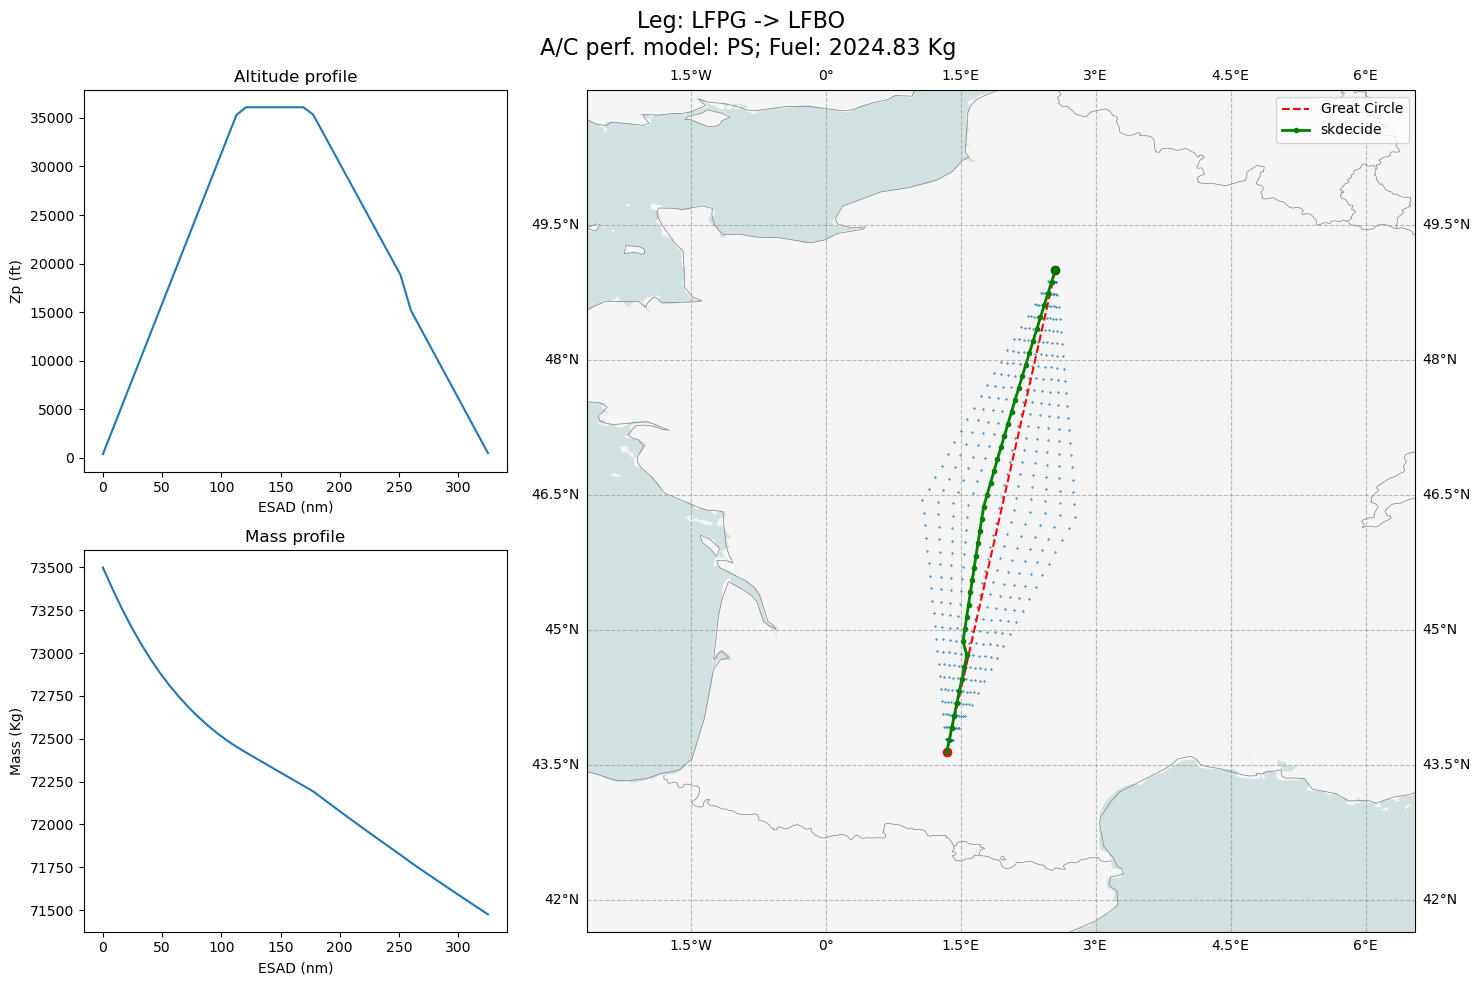

Goal reached after 40 steps!


In [8]:
domain_factory = lambda: FlightPlanningDomain(
    origin,
    destination,
    aircraft,
    weather_date=weather_date,
    heuristic_name=heuristic,
    perf_model_name="PS", # a/c performance model
    objective=cost_function,
    fuel_loop=False,
    graph_width="normal",
)

domain = domain_factory()

with Astar(
heuristic=lambda d, s: d.heuristic(s), domain_factory=domain_factory, parallel=False
) as solver:
    domain.solve_with(
        solver=solver, 
        domain_factory=domain_factory)

    domain.custom_rollout(
        solver=solver)

## Longer routes

Finally, we will make a long haul flight: Cartagena (ICAO: SKCG) - Toulouse (ICAO: LFBO), with an A380. For computational purposes, we will also modify the heuristic function:

/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/homebrew/anaconda3/envs/

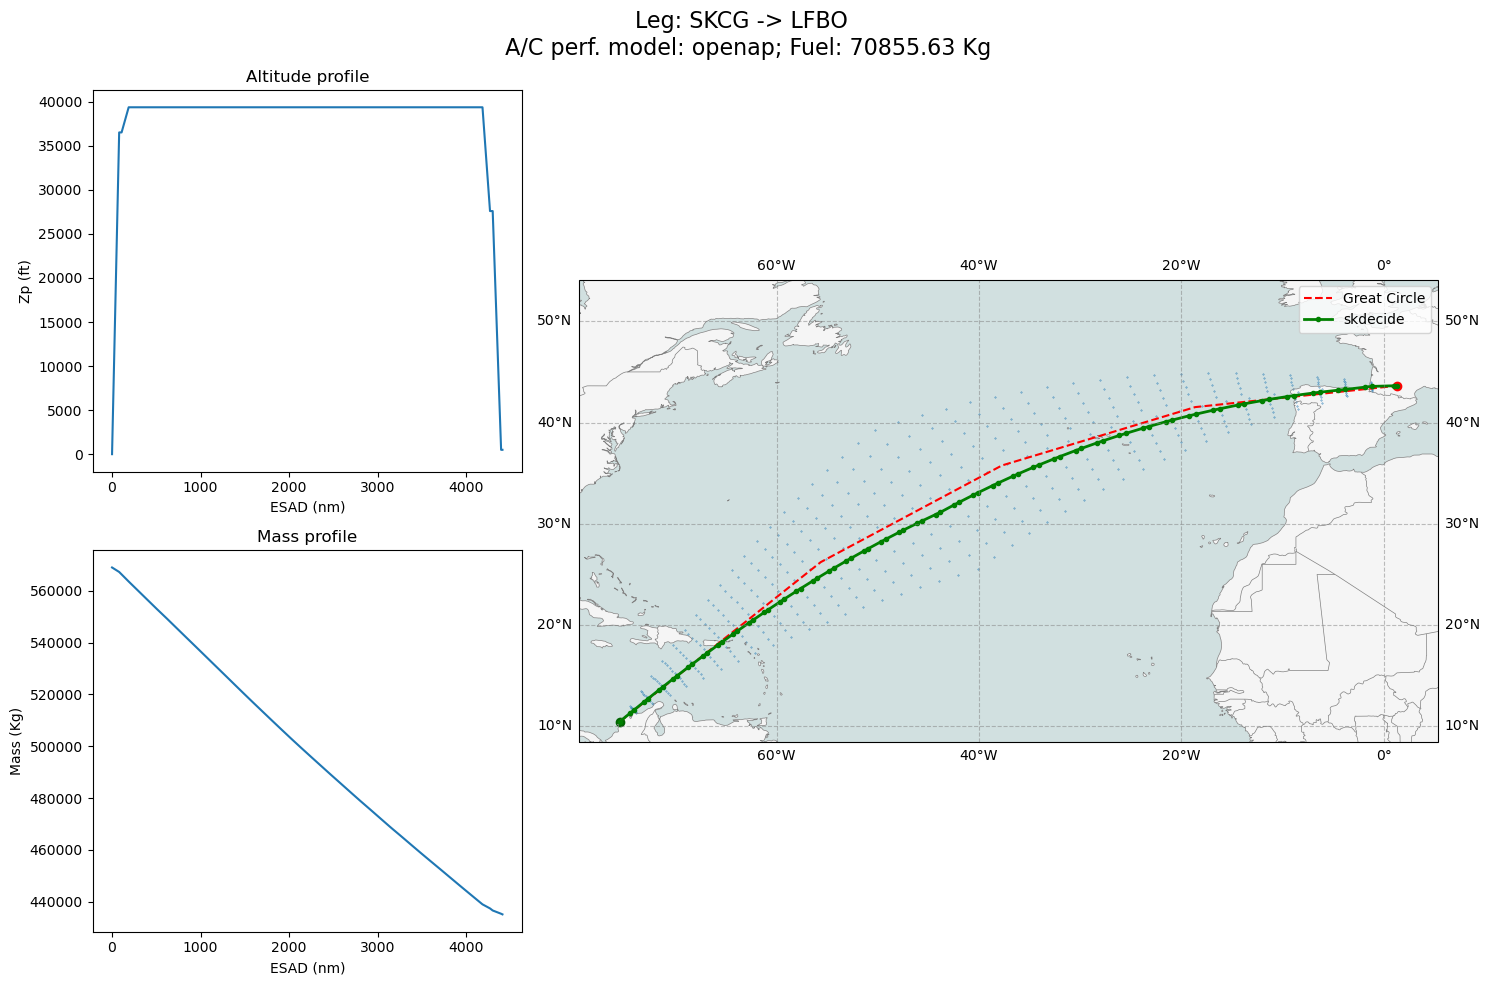

Goal reached after 40 steps!


In [9]:
heuristic = "lazy_fuel"

origin = "SKCG"
destination = "LFBO"
aircraft = "A388"

domain_factory = lambda: FlightPlanningDomain(
    origin,
    destination,
    aircraft,
    weather_date=weather_date,
    heuristic_name=heuristic,
    perf_model_name="openap", # a/c performance model
    objective=cost_function,
    fuel_loop=False,
    graph_width="normal",
)

domain = domain_factory()

with Astar(
heuristic=lambda d, s: d.heuristic(s), domain_factory=domain_factory, parallel=False
) as solver:
    domain.solve_with(
        solver=solver, 
        domain_factory=domain_factory)

    domain.custom_rollout(
        solver=solver)

/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/anaconda3/envs/test_dev_skdecide/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/homebrew/anaconda3/envs/

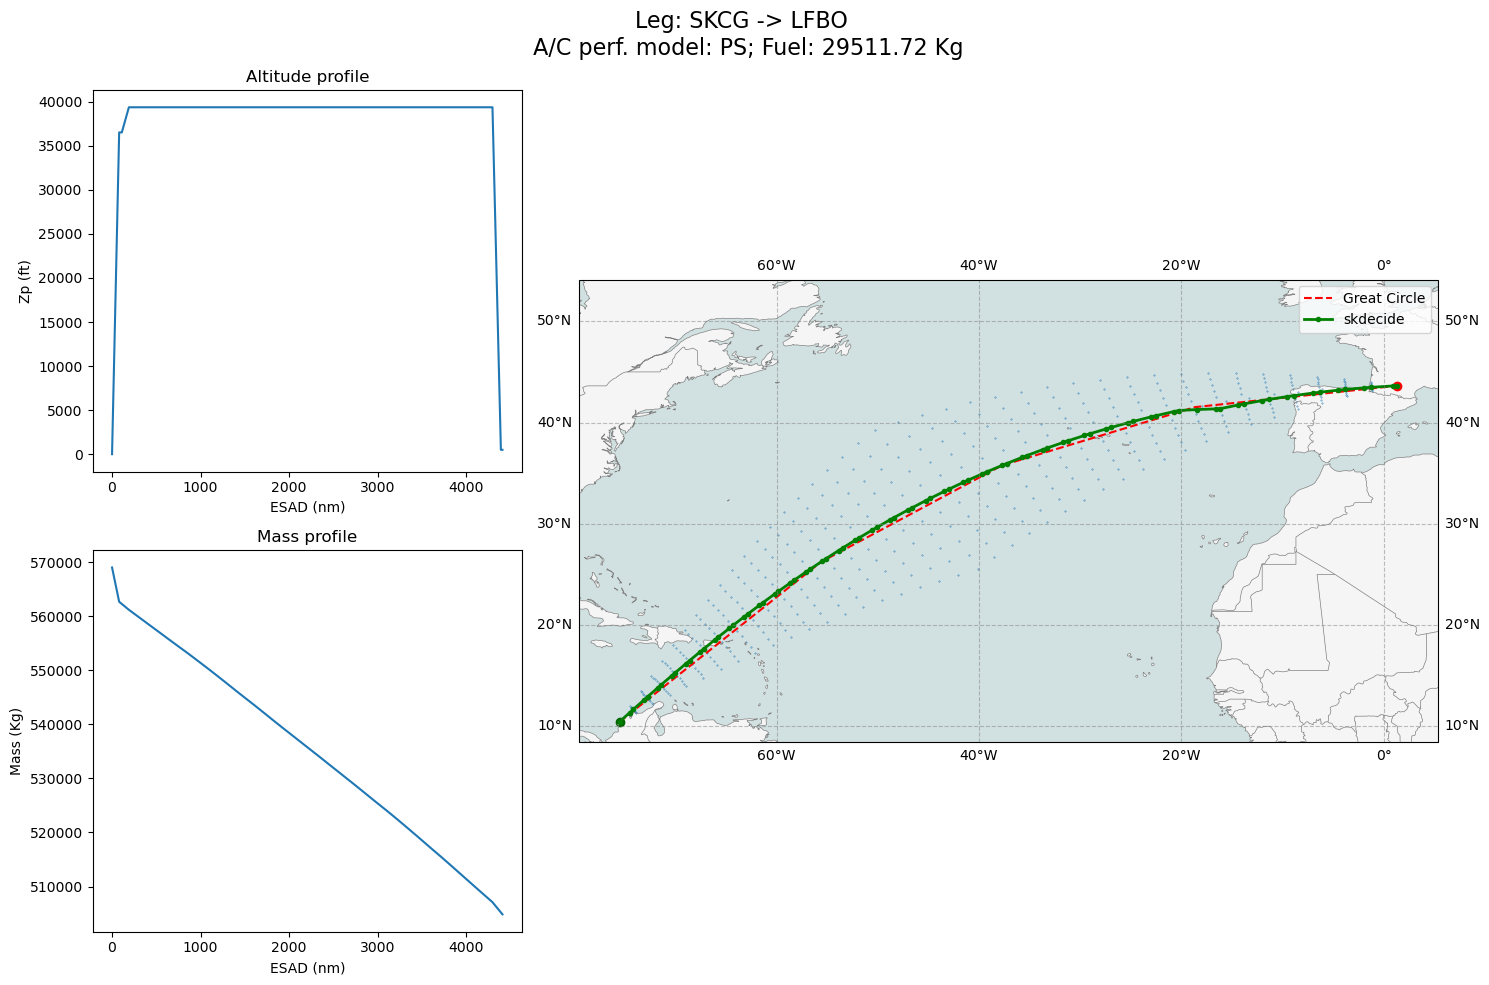

Goal reached after 40 steps!


In [10]:
origin = "SKCG"
destination = "LFBO"
aircraft = "A388"

domain_factory = lambda: FlightPlanningDomain(
    origin,
    destination,
    aircraft,
    weather_date=weather_date,
    heuristic_name=heuristic,
    perf_model_name="PS", # a/c performance model
    objective=cost_function,
    fuel_loop=False,
    graph_width="normal",
)

domain = domain_factory()

with Astar(
heuristic=lambda d, s: d.heuristic(s), domain_factory=domain_factory, parallel=False
) as solver:
    domain.solve_with(
        solver=solver, 
        domain_factory=domain_factory)

    domain.custom_rollout(
        solver=solver)